# Introduction

### This notebook aims to detect anomalies in financial markets using the XGBoost model.

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Data Cleaning

In [184]:
dataset = pd.read_excel('../data/FinancialMarketData.xlsx', sheet_name='EWS' )

# moving averages   
dataset['VIX_moving_average'] = dataset['VIX'].rolling(window=7).mean()
dataset['BDIY_moving_average'] = dataset['BDIY'].rolling(window=7).mean()
dataset['CRY_moving_average'] = dataset['CRY'].rolling(window=7).mean()
dataset['Cl1_moving_average'] = dataset['Cl1'].rolling(window=7).mean()
dataset['USGG2YR_moving_average'] = dataset['USGG2YR'].rolling(window=7).mean()
dataset['GT10_moving_average'] = dataset['GT10'].rolling(window=7).mean()
dataset['DXY_moving_average'] = dataset['DXY'].rolling(window=7).mean()

# Ratios
dataset['DXY_to_VIX'] = dataset['DXY'] / dataset['VIX']

# Differences
dataset['VIX_diff'] = dataset['VIX'].diff()

dataset['Year'] = dataset['Data'].dt.year
dataset['Month'] = dataset['Data'].dt.month
dataset['Day'] = dataset['Data'].dt.day
dataset['DayOfWeek'] = dataset['Data'].dt.dayofweek

#correlation
correlation_matrix = dataset.corr()
low_cor_cols=correlation_matrix['Y'][abs(correlation_matrix['Y'])<0.04].index

#cleaning data
dataset_cleaned=dataset.drop(columns=low_cor_cols)

#droping Date Column
dataset_cleaned = dataset_cleaned.drop(columns=['Data'])

dataset_cleaned.describe()


,Y,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,GTDEM30Y,...,MXIN,MXCN,VIX_moving_average,BDIY_moving_average,CRY_moving_average,DXY_moving_average,DXY_to_VIX,VIX_diff,Year,DayOfWeek
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,...,1111.000000,1111.000000,1105.000000,1105.000000,1105.000000,1105.000000,1111.000000,1110.00000,1111.000000,1111.0
mean,0.213321,0.036153,2259.860486,245.247649,90.934982,106.605734,1.569618,60.708101,19.992169,3.039282,...,693.156616,53.933159,19.990050,2262.404913,245.622300,90.901003,5.192057,-0.00364,2010.169217,1.0
std,0.409837,0.349453,2017.811888,68.278081,11.379095,12.840754,0.212340,25.900813,8.642157,1.779526,...,405.527014,24.738356,8.134382,2000.395563,67.922580,11.344388,1.780666,3.14486,6.151407,0.0
min,0.000000,-0.974000,291.000000,106.292900,71.329000,75.940000,1.172300,10.010000,9.430000,-0.471000,...,112.600000,13.460000,10.151429,322.857143,119.503429,72.127000,1.291721,-19.23000,2000.000000,1.0
25%,0.000000,-0.191000,990.000000,184.705650,81.240500,101.565000,1.417900,39.625000,13.640000,1.288000,...,278.385000,28.565000,14.121429,1000.000000,185.126243,81.392286,3.808384,-1.34000,2005.000000,1.0
50%,0.000000,0.035000,1518.000000,234.560000,89.716000,108.720000,1.562200,57.400000,17.980000,3.572000,...,691.530000,58.740000,17.672857,1518.857143,236.862857,89.751571,5.082427,-0.10000,2010.000000,1.0
75%,0.000000,0.260500,2685.500000,301.539250,97.404000,116.220000,1.677050,79.640000,23.625000,4.582500,...,1014.750000,68.460000,23.600000,2708.000000,302.978571,97.305000,6.438958,1.12000,2015.000000,1.0
max,1.000000,0.991000,11793.000000,467.570000,119.820000,134.630000,2.085200,140.970000,75.910000,6.254000,...,1730.510000,129.200000,60.937143,10799.428571,446.368571,118.951429,10.005823,28.61000,2021.000000,1.0


# Data Preperation

In [183]:
X= dataset_cleaned.drop(columns=['Y'])
y=dataset_cleaned['Y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training

## Handling Class Imbalance

In [185]:
class_counts = Counter(y_train)
negatives = class_counts[0]  # Normal class
positives = class_counts[1]  # Anomaly class

# Scale_pos_weight calcul
scale_pos_weight = negatives / positives
print(f"Scale Pos Weight: {scale_pos_weight}")


Scale Pos Weight: 3.649214659685864


## Training the XGBoost Classifier

In [187]:
# Model inisialization
model = XGBClassifier(
    n_estimators=131, 
    learning_rate=0.3, 
    random_state=43, 
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

#  prediction model
y_pred = model.predict(X_test)

print("Classification Report :")
print(classification_report(y_test, y_pred))


Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       177
           1       0.83      0.74      0.78        46

    accuracy                           0.91       223
   macro avg       0.88      0.85      0.86       223
weighted avg       0.91      0.91      0.91       223



# Investment Strategy Implementation

### In this section, we will define and implement a data-driven investment strategy based on the model's predictions.


In [211]:
dataset_cleaned['Anomaly'] = model.predict_proba(X)[:, 1] >= 0.1
dataset_cleaned['price'] = dataset_cleaned['VIX']

def define_strategy(row):
    global entry_price, position  # using global var to keep the state 

    # Buy if :
    if row['Anomaly'] and row['VIX'] < row['VIX_moving_average']:
        if position == 0:  # Buy only if there is not an active position 
            entry_price = row['price']
            position = cash / entry_price  # Calculate the quantity bought
            return 'Buy'
    
    # Sell if there is an active position
    elif position > 0 and (row['price'] > entry_price * 1.1 or row['price'] < entry_price * 0.95):
        position = 0  # Close the position
        entry_price = None  # Reset entry price
        return 'Sell'
    
    # Do not trade on weekends
    elif row['DayOfWeek'] in [5, 6]:  # Assuming weekends are Saturday and Sunday
        return 'Hold'

    # Default action: hold
    return 'Hold'


# Applied  the strategy
dataset_cleaned['Strategy'] = dataset_cleaned.apply(define_strategy, axis=1)



## Backtesting

In [212]:
# Initialization
initial_portfolio = 100000  # Initial capital
portfolio = initial_portfolio
position = 0  # Current position (amount of asset held)
entry_price = None  # Entry price for an active position
cash = initial_portfolio  # Uninvested cash amount
transaction_fee = 0.001  # Transaction fee (0.1% per transaction)

portfolio_values = []  # List to store portfolio values at each step
transactions = []  # List to log transactions

# Strategy simulation
for index, row in dataset_cleaned.iterrows():
    # Buy if the strategy indicates 'Buy' and no active position
    if row['Strategy'] == 'Buy' and position == 0:
        entry_price = row['price'] * (1 + transaction_fee)  # Include buy transaction fee
        position = cash / entry_price  # Calculate the amount bought
        cash = 0  # All cash is invested
        transactions.append(f"Buy at {row['price']} (adjusted: {entry_price}) on index {index}")
    
    # Sell if the strategy indicates 'Sell' and there is an active position
    elif row['Strategy'] == 'Sell' and position > 0:
        sell_price = row['price'] * (1 - transaction_fee)  # Include sell transaction fee
        cash = position * sell_price  # Calculate cash gained
        portfolio = cash  # Update portfolio value
        position = 0  # Reset the position
        transactions.append(f"Sell at {row['price']} (adjusted: {sell_price}) on index {index}")
    
    # Append the current portfolio value
    current_portfolio_value = cash + (position * row['price'] if position > 0 else 0)
    portfolio_values.append(current_portfolio_value)

# Calculate total return
total_return = (portfolio_values[-1] - initial_portfolio) / initial_portfolio * 100
print(f"Total Return: {total_return:.2f}%")

# Add the Portfolio_Value column to the dataset
dataset_cleaned['Portfolio_Value'] = portfolio_values

# Print the final portfolio value
print(f"Final Portfolio Value: {portfolio_values[-1]}")

# Print the transaction log
print("\nTransactions:")
for transaction in transactions:
    print(transaction)




Total Return: 2540.03%
Final Portfolio Value: 2640034.058837837

Transactions:
Buy at 25.24 (adjusted: 25.265239999999995) on index 15
Sell at 28.5 (adjusted: 28.4715) on index 16
Buy at 24.34 (adjusted: 24.36434) on index 18
Sell at 23.05 (adjusted: 23.02695) on index 21
Buy at 24.99 (adjusted: 25.014989999999997) on index 47
Sell at 28.73 (adjusted: 28.70127) on index 50
Buy at 21.98 (adjusted: 22.00198) on index 56
Sell at 24.69 (adjusted: 24.66531) on index 58
Buy at 28.49 (adjusted: 28.518489999999996) on index 67
Sell at 24.2 (adjusted: 24.1758) on index 68
Buy at 19.58 (adjusted: 19.599579999999996) on index 73
Sell at 22.34 (adjusted: 22.31766) on index 75
Buy at 18.92 (adjusted: 18.93892) on index 77
Sell at 23.25 (adjusted: 23.22675) on index 78
Buy at 20.48 (adjusted: 20.50048) on index 83
Sell at 24.4 (adjusted: 24.3756) on index 84
Buy at 22.0 (adjusted: 22.022) on index 85
Sell at 25.85 (adjusted: 25.824150000000003) on index 86
Buy at 32.0 (adjusted: 32.032) on index 93


##  Visualization Of The Portfolio

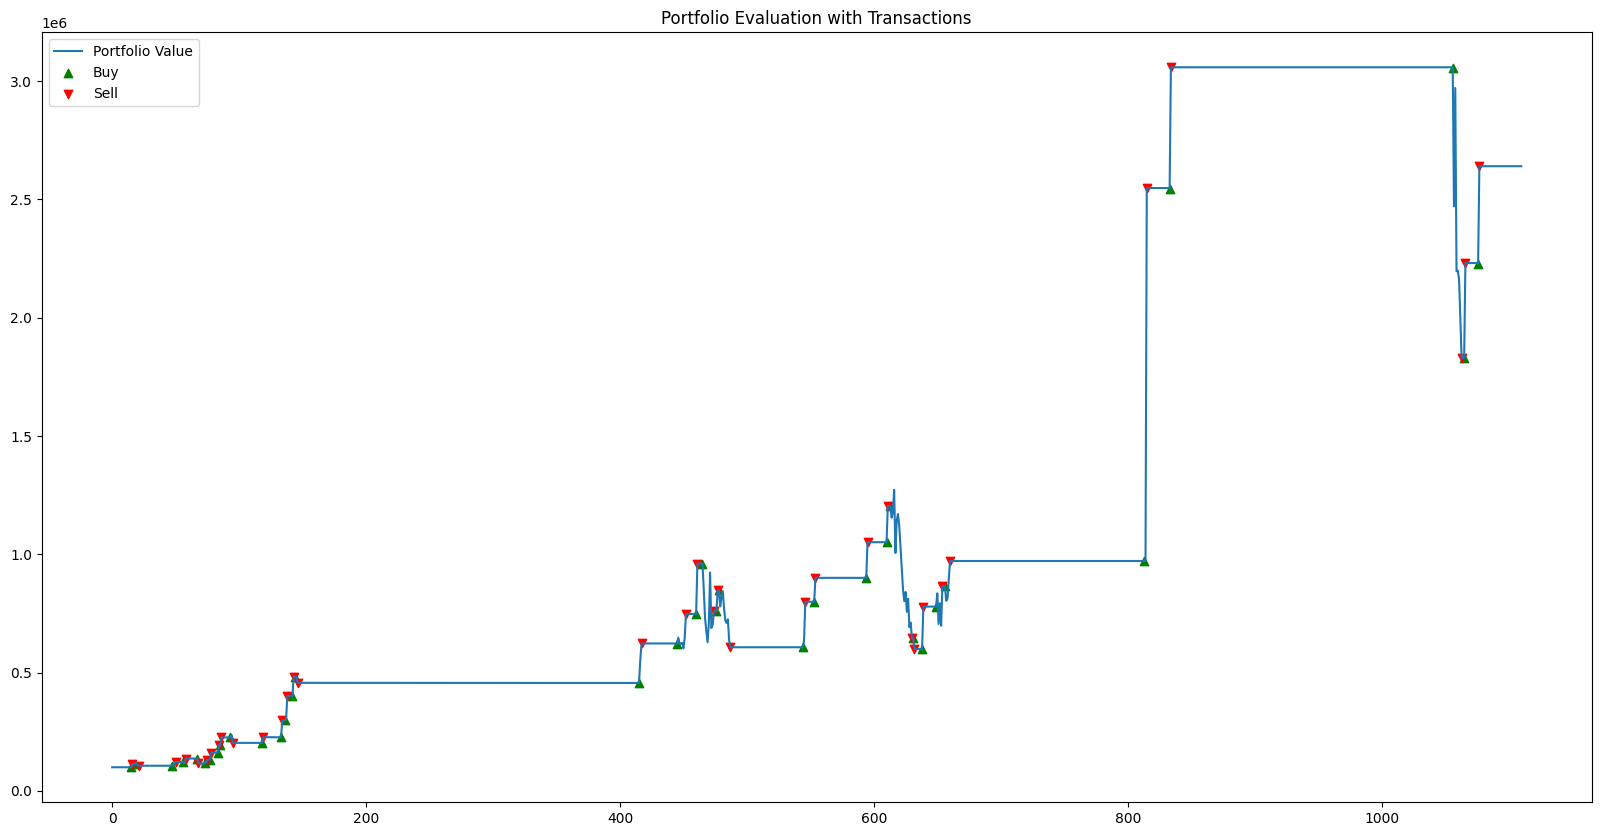

In [213]:
buy_points = dataset_cleaned[dataset_cleaned['Strategy'] == 'Buy'].index
sell_points = dataset_cleaned[dataset_cleaned['Strategy'] == 'Sell'].index

plt.figure(figsize=(20, 10))
plt.plot(dataset_cleaned['Portfolio_Value'], label="Portfolio Value")
plt.scatter(buy_points, dataset_cleaned.loc[buy_points, 'Portfolio_Value'], color='green', label='Buy', marker='^')
plt.scatter(sell_points, dataset_cleaned.loc[sell_points, 'Portfolio_Value'], color='red', label='Sell', marker='v')
plt.title("Portfolio Evaluation with Transactions")
plt.legend()
plt.show()